<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score,\
precision_score, recall_score, precision_recall_curve
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import re
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('/datasets/Churn.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


**После общего ознакомления можно сделать некоторые выводы:**
* Столбец Tenure (сколько лет человек является клиентом банка) имеет пустые значения (NaN)
* Имеются столбцы которые не несут полезной информации для исследования: RowNumber(номер строки в таблице, думаю не требует пояснений его бесполезности), CustomerId и Surname (фасилия и уникальный индификатор клиента для построения общей картины о клиентах тоже не потребуются)
* Имеются катекгориальные признаки Geography(страна) и Gender(пол) *(со странами было бы круто проверить на уникальность, но думаю это перебор)
* *Надобы привести названия к правильной запитси
* Провести проверку на выбросы и дупликаты
* Разбить данные на выборки
* Маштабировать соответствующие признаки


In [4]:
data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower()for i in data.columns]

In [5]:
data.corr()

,row_number,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
row_number,1.000000,0.004202,0.005840,0.000783,-0.007322,-0.009067,0.007246,0.000599,0.012044,-0.005988,-0.016571
customer_id,0.004202,1.000000,0.005308,0.009497,-0.021418,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248
credit_score,0.005840,0.005308,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
age,0.000783,0.009497,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
tenure,-0.007322,-0.021418,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
balance,-0.009067,-0.012419,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
num_of_products,0.007246,0.016972,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
has_cr_card,0.000599,-0.014025,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
is_active_member,0.012044,0.001665,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
estimated_salary,-0.005988,0.015271,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097


Видимой зависимости не прослеживается, заменим значения на 0 или удалим, что сделать в итоге выберем по результативности модели.

In [6]:
#data.dropna(subset=['tenure'], inplace=True)
data = data.fillna(0)

Удалим ненужные данные

In [7]:
data.drop(['row_number', 'customer_id', 'surname'], axis='columns', inplace=True)

Проверим значения на выбросы и дупликаты

In [8]:
data.describe()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.543400,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,3.111573,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,4.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Распределения значений не вызывают подозрений.

In [9]:
data.duplicated().sum()

0

Разберемся с категориальными признаками

Посмотрим уникальные значения geography

In [10]:
data['geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [11]:
data_ohe = pd.get_dummies(data, drop_first=True)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  float64
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


In [13]:
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       10000 non-null  int64  
 1   age                10000 non-null  int64  
 2   tenure             10000 non-null  float64
 3   balance            10000 non-null  float64
 4   num_of_products    10000 non-null  int64  
 5   has_cr_card        10000 non-null  int64  
 6   is_active_member   10000 non-null  int64  
 7   estimated_salary   10000 non-null  float64
 8   exited             10000 non-null  int64  
 9   geography_Germany  10000 non-null  uint8  
 10  geography_Spain    10000 non-null  uint8  
 11  gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


Можно приступать к разбиению данных на выборки.
Зададим random_state, что бы не ошибиться 

In [14]:
random_state=12345

In [15]:
target = data_ohe['exited']
features = data_ohe.drop('exited', axis=1)
features_train, features_rest, target_train, target_rest = train_test_split(features, target, test_size=.4, random_state=random_state)
features_valid, features_test, target_valid, target_test = train_test_split(features_rest, target_rest, test_size=.5, random_state=random_state)

Проверим размеры выборок

In [16]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(6000, 11)
(2000, 11)
(2000, 11)


Маштабируем признаки 

In [17]:
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 
                 'estimated_salary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

pd.options.mode.chained_assignment = None 

## Исследование задачи

Обучим модели и изучим значения их метрик (f1 и accuracy)

In [18]:
score = pd.DataFrame(columns=['model_name', 'f1', 'accuracy', 'auc_roc'])


In [19]:
best_model_lr = None
best_accuracy = 0
best_f1 = 0
best_auc_roc = 0
for max_iter in [100,200,300,400,500,1000]:
    model = LogisticRegression(random_state=random_state, max_iter=max_iter,solver='liblinear') 
    model.fit(features_train,target_train)
    predicted = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted) 
    if f1 > best_f1:
        best_model_lr = model
        best_accuracy = model.score(features_valid,target_valid)
        probabilities = model.predict_proba(features_valid)
        probabilities_one =  probabilities[:, 1]
        best_auc_roc = roc_auc_score(target_valid,probabilities_one)
        best_f1 = f1

print(best_f1,best_accuracy)
score = score.append({'model_name' : 'LogisticRegression', 'f1': best_f1, 'accuracy': best_accuracy, 'auc_roc':best_auc_roc},
                              ignore_index=True)
score

0.33389544688026984 0.8025


,model_name,f1,accuracy,auc_roc
0,LogisticRegression,0.333895,0.8025,0.758632


In [20]:
best_model_dtc = None
best_accuracy = 0
best_f1 = 0
best_auc_roc = 0
for min_samples_split in range (2,5):
    for splitter in ['best','random']:
            for max_depth in range(1, 20):
                model = DecisionTreeClassifier(random_state=random_state, max_depth=max_depth,\
                                   splitter=splitter,min_samples_split=min_samples_split) 
                model.fit(features_train,target_train)
                best_model_dtc = model
                best_accuracy = model.score(features_valid,target_valid)
                probabilities = model.predict_proba(features_valid)
                probabilities_one =  probabilities[:, 1]
                best_auc_roc = roc_auc_score(target_valid,probabilities_one)
                best_f1 = f1
score = score.append({'model_name' : 'DecisionTreeClassifier', 'f1': best_f1, 'accuracy': best_accuracy,'auc_roc':best_auc_roc},
                              ignore_index=True)
score

,model_name,f1,accuracy,auc_roc
0,LogisticRegression,0.333895,0.8025,0.758632
1,DecisionTreeClassifier,0.333895,0.7910,0.690880


In [21]:
best_model_rfc = None
best_accuracy = 0
best_f1 = 0
for criterion in ['gini', 'entropy']:
    for max_features in ['sqrt', 'log2']:
        for n_estimators in range(5,15):
            for max_depth in range(5,15):
                model = RandomForestClassifier(random_state=random_state, criterion=criterion,
                                    max_features=max_features, max_depth=max_depth, n_estimators=n_estimators)
                model.fit(features_train,target_train)
                predicted = model.predict(features_valid)
                f1 = f1_score(target_valid, predicted) 
                if f1 > best_f1:
                    best_model_rfc = model
                    best_accuracy = model.score(features_valid,target_valid)
                    probabilities = model.predict_proba(features_valid)
                    probabilities_one =  probabilities[:, 1]
                    best_auc_roc = roc_auc_score(target_valid,probabilities_one)
                    best_f1 = f1
score = score.append({'model_name' : 'RandomForestClassifier', 'f1': best_f1, 'accuracy': best_accuracy,'auc_roc':best_auc_roc},
                              ignore_index=True)
score

,model_name,f1,accuracy,auc_roc
0,LogisticRegression,0.333895,0.8025,0.758632
1,DecisionTreeClassifier,0.333895,0.7910,0.690880
2,RandomForestClassifier,0.598519,0.8645,0.829207


,model_name,f1,accuracy,auc_roc
0,LogisticRegression,0.333895,0.8025,0.758632
1,DecisionTreeClassifier,0.333895,0.7910,0.690880
2,RandomForestClassifier,0.598519,0.8645,0.829207


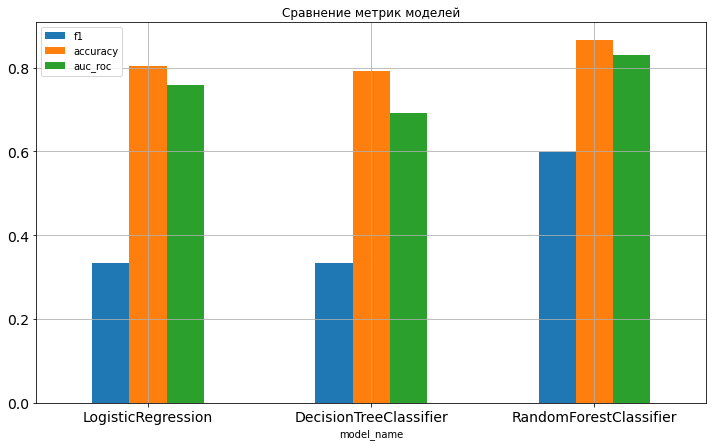

In [22]:
score.plot(x='model_name', kind='bar', figsize=(12,7), fontsize=14, grid=True, title='Сравнение метрик моделей' )
plt.xticks(rotation=0)
score

Значение метрики f1 оставляет желать лучшего, а вот значение accuracy подозрительно высоко, такое возможно при дисбалансе классов, проверим.

0    0.7963
1    0.2037
Name: exited, dtype: float64


<AxesSubplot:>

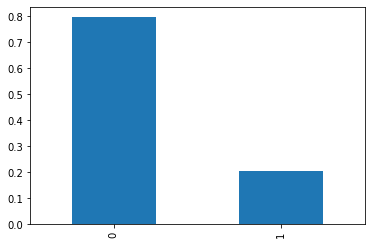

In [23]:
ballans = data_ohe['exited'].value_counts(normalize=True)
print(ballans)
ballans.plot(kind='bar')

Заметна явная диспропорция в значениях, то есть такая высокая точность может быть достигнута и константной моделью. Будем исправлять. работать будем работать с моделью случайный лес, ее результаты лучше всех.

## Борьба с дисбалансом

**Попробуем два варианта решение проблемы**
* Взвешивание классов
* Увиличение выборки

In [24]:
score_one = pd.DataFrame(columns=['Метод', 'f1', 'accuracy'])
best_model_rfc = None
best_accuracy = 0
best_f1 = 0
best_auc_roc = 0
for criterion in ['gini', 'entropy']:
    for max_features in ['sqrt', 'log2']:
        for n_estimators in range(5,15):
            for max_depth in range(5,15):
                model = RandomForestClassifier(random_state=random_state, criterion=criterion,
                                    max_features=max_features, max_depth=max_depth, n_estimators=n_estimators,class_weight='balanced')
                model.fit(features_train,target_train)
                predicted = model.predict(features_valid)
                f1 = f1_score(target_valid, predicted) 
                if f1 > best_f1:
                    best_model_rfc = model
                    probabilities = model.predict_proba(features_valid)
                    probabilities_one =  probabilities[:, 1]
                    best_auc_roc = roc_auc_score(target_valid,probabilities_one)
                    best_accuracy = model.score(features_valid,target_valid)
                    best_f1 = f1
score_one = score_one.append({'Метод' : 'Взвешивание классов', 'f1': best_f1, 'accuracy': best_accuracy},
                              ignore_index=True)
print(best_f1,best_accuracy,best_auc_roc)

0.6248671625929862 0.8235 0.848422595104011


Accuracy неожиданно упала, а вот f1 стала лучше.

In [25]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled


In [26]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
target_upsampled.value_counts(normalize=True)

0    0.501043
1    0.498957
Name: exited, dtype: float64

In [27]:
best_model_rfc = None
best_accuracy = 0
best_f1 = 0
best_auc_roc = 0
for criterion in ['gini', 'entropy']:
    for max_features in ['sqrt', 'log2']:
        for n_estimators in range(5,15):
            for max_depth in range(5,15):
                model = RandomForestClassifier(random_state=random_state, criterion=criterion,
                                    max_features=max_features, max_depth=max_depth, n_estimators=n_estimators)
                model.fit(features_upsampled,target_upsampled)
                predicted = model.predict(features_valid)
                f1 = f1_score(target_valid, predicted) 
                if f1 > best_f1:
                    best_model_rfc = model
                    probabilities = model.predict_proba(features_valid)
                    probabilities_one =  probabilities[:, 1]
                    best_auc_roc = roc_auc_score(target_valid,probabilities_one)
                    best_accuracy = model.score(features_valid,target_valid)
                    best_f1 = f1
score = score.append({'model_name' : 'RandomForestClassifier', 'f1': best_f1, 'accuracy': best_accuracy},
                              ignore_index=True)
print(best_f1,best_accuracy,best_auc_roc)

0.625 0.841 0.841746865151616


Данный способ порадовал, так и оставим, приступаем к тестированию модели

## Тестирование модели

,f1,accuracy,auc_roc
0,0.625,0.8325,0.835073


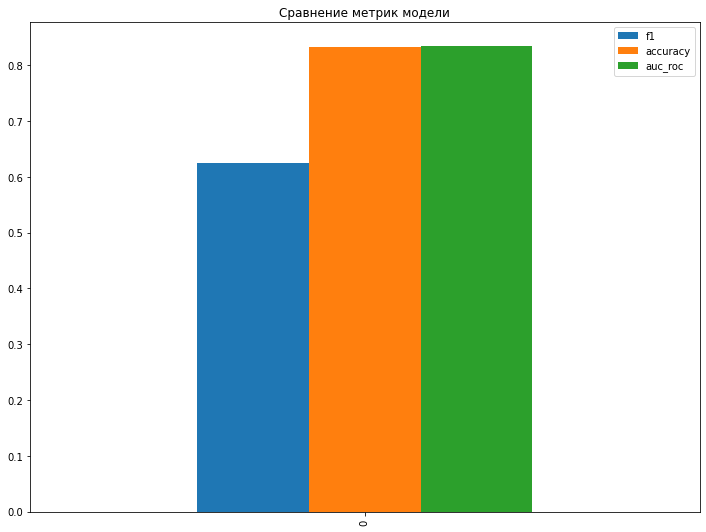

In [28]:
predicted_test = best_model_rfc.predict(features_test)
f1_test = f1_score(target_test, predicted_test)
probabilities_test = best_model_rfc.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test,probabilities_one_test)
accuracy_test = best_model_rfc.score(features_test,target_test)
score = pd.DataFrame(columns=['f1', 'accuracy','auc_roc'])
score = score.append({'f1': best_f1, 'accuracy': accuracy_test, 'auc_roc':auc_roc},
                              ignore_index=True)
score.plot(kind='bar',title='Сравнение метрик модели',figsize=(12,9))
score

Значения метрик говорят о успешном выборе модели и обработке данных.

**Краткий вывод**
* Предобработали данные, данные были получены сразу без особых нареканий с небольшим кол-ом пропусков
* Разобрались с категориальными признаками
* Выбрали модель случайный лес, т.к. у нее наи лучшие показатели
* Повысили точность и качество модели, посредством перебора гиперпараметров и устранения дисбаланса 
* На самом деле случаный лес, паказал хорошие результаты даже с дисболансом в классах 